# Discrete Optimization of a Resource-Constrained Controls Development Schedule
### EEC 289Q - Final Project

This notebook presents several algorithms aimed at optimizing the scheduling for a real-life project. The algorithms presented are:
1) Heuristics Algorithm - Priority Based Scheduling (two variations)
2) Simulated Annealing

The notebook takes input data from the ./data folder for the task lists, and resource availability for the development of a single PCM feature, and the full development of all 15 features (resources scaled accordingly).
<br>Note: Parts of the code/documentation was enhanced using ChatGPT</br>

## Setup Instructions

### Project Setup Instructions

This guide will walk you through setting up a new Conda environment, installing necessary dependencies, and ensuring data files are correctly placed to run the notebook for the Resource-Constrained Project Scheduling Problem (RCPSP).

#### Step 1: Create a New Conda Environment

We recommend using Conda to manage your environments and dependencies. If you do not have Conda installed, please install [Miniconda](https://docs.conda.io/en/latest/miniconda.html) or [Anaconda](https://www.anaconda.com/products/individual).
<br>To create a new Conda environment, run the following command in your terminal:</br>

```sh
conda create -n rcpsp_env python=3.12.2
```
#### Step 2: Activate the Conda Environment
Activate the newly created environment with:
```sh
conda activate rcpsp_env
```
#### Step 3: Install Requirements Using pip
With your Conda environment activated, install the required Python packages listed in requirements.txt using pip:
```sh
pip install -r requirements.txt
```
Make sure requirements.txt is in the current directory where the command is run.

#### Step 4: Data Files Setup
Ensure that the following data files:
- limited_pcm_execution_schedule.csv
- full_pcm_execution_schedule.csv
- limited_pcm_resources.csv
- full_pcm_resources.csv
are placed within a subdirectory called /data relative to the notebook's directory.

<br>Your directory structure should look like this:</br>
```sh
.
+-- data
|   +-- pcm_execution_schedule.csv
|   +-- full_pcm_execution_schedule.csv
|   +-- limited_pcm_resources.csv
|   +-- full_pcm_resources.csv
+-- EEC289Q_FinalProject_ProjectSchedule.ipynb
+-- requirements.txt
```

## Overall Functions

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import math
import random
import time

### Plot Gantt Chart Function

In [2]:
def plot_gantt_chart(schedule_df):
    # Convert start_day and end_day to datetime objects (assuming start_day 0 is today)
    today = pd.to_datetime('today')
    schedule_df['start_datetime'] = schedule_df['start_day'].apply(lambda x: today + timedelta(days=x))
    schedule_df['end_datetime'] = schedule_df['end_day'].apply(lambda x: today + timedelta(days=x))
    
    # Create a color map for resources
    colors = plt.cm.tab20(range(len(schedule_df['resource_id'].unique())))
    color_map = dict(zip(schedule_df['resource_id'].unique(), colors))
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for i, task in schedule_df.iterrows():
        start = task['start_datetime']
        end = task['end_datetime']
        resource_id = task['resource_id']
        ax.barh(task['task_id'], end - start, left=start, color=color_map[resource_id], edgecolor='black', label=f'Resource {resource_id}')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Task ID')
    
    # Improve layout of date ticks
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    
    # Create a legend for resources
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates
    plt.legend(by_label.values(), by_label.keys())
    
    plt.title('Task Schedule Gantt Chart')
    plt.tight_layout()
    plt.show()


### Load DataFrames

In [3]:
def load_dataframes(task_path, resource_path):
    tasks = pd.read_csv(task_path)
    resources = pd.read_csv(resource_path)
    return tasks, resources

In [4]:
limited_pcm_sched_path = './data/limited_pcm_execution_schedule.csv'
limited_pcm_resources_path = './data/limited_pcm_resources.csv'
full_pcm_sched_path = './data/full_pcm_execution_schedule.csv'
full_pcm_resources_path = './data/full_pcm_resources.csv'

## Heuristic Algorithm - Priority-Based Scheduling

In [5]:
def heuristic_schedule(tasks, resources):
    tasks['dependencies'] = tasks['dependencies'].apply(eval)
    tasks['scheduled'] = False
    resources['next_available'] = 1
    scheduled_tasks = {}  # Use a dictionary to track scheduled tasks by task_id

    while not tasks['scheduled'].all():
        for index, task in tasks.iterrows():
            if task['scheduled']:
                continue  # Skip already scheduled tasks

            # Ensure all dependencies are scheduled before proceeding
            if any(not tasks.loc[tasks['task_id'] == dep, 'scheduled'].iloc[0] for dep in task['dependencies']):
                continue

            resources_sorted = resources.sort_values(by=['next_available', 'daily_hours'], ascending=[True, False])
            selected_resource = resources_sorted.iloc[0]

            # Calculate the earliest start day after all dependencies have ended
            if task['dependencies']:
                latest_dependency_end_day = max(scheduled_tasks[dep]['end_day'] for dep in task['dependencies'])
                start_day = max(selected_resource['next_available'], latest_dependency_end_day + 1)
            else:
                start_day = selected_resource['next_available']

            days_needed = math.ceil(task['story_points'] / selected_resource['daily_hours'])
            end_day = start_day + days_needed - 1

            tasks.at[index, 'scheduled'] = True
            resources.at[selected_resource.name, 'next_available'] = end_day + 1

            # Record the scheduling details in the dictionary
            scheduled_tasks[task['task_id']] = {
                'task_id': task['task_id'],
                'resource_id': selected_resource.name,
                'start_day': start_day,
                'end_day': end_day,
                'dependencies': task['dependencies']
            }

    # Convert the scheduled_tasks dictionary to a DataFrame
    schedule_df = pd.DataFrame.from_dict(scheduled_tasks, orient='index')
    return schedule_df


## Heuristic Resource-Fit Scheduling

In [6]:
def heuristic_schedule_fit(tasks, resources):
    tasks['dependencies'] = tasks['dependencies'].apply(eval)
    tasks['scheduled'] = False
    resources['next_available'] = 1  # Initialize all resources as available from day 1
    scheduled_tasks = {}  # Use a dictionary to track scheduled tasks by task_id

    while not tasks['scheduled'].all():
        for index, task in tasks.iterrows():
            if task['scheduled']:
                continue  # Skip already scheduled tasks

            # Ensure all dependencies are scheduled before proceeding
            if any(not tasks.loc[tasks['task_id'] == dep, 'scheduled'].iloc[0] for dep in task['dependencies']):
                continue

            # Optimize resource selection based on availability and task requirements
            # Calculate a fit score as the absolute difference between task story points and resource daily hours
            resources['fit_score'] = abs(resources['daily_hours'] - task['story_points'])
            resources_sorted = resources.sort_values(by=['next_available', 'fit_score', 'daily_hours'], ascending=[True, True, False])
            selected_resource = resources_sorted.iloc[0]

            # Calculate the earliest start day considering dependencies
            latest_dependency_end_day = max([scheduled_tasks[dep]['end_day'] for dep in task['dependencies']], default=0) if task['dependencies'] else 0
            start_day = max(selected_resource['next_available'], latest_dependency_end_day + 1)

            # Calculate the number of days needed to complete the task
            days_needed = math.ceil(task['story_points'] / selected_resource['daily_hours'])
            end_day = start_day + days_needed - 1

            # Mark the task as scheduled and update the resource's next available day
            tasks.at[index, 'scheduled'] = True
            resources.at[selected_resource.name, 'next_available'] = end_day + 1

            # Record the scheduling details
            scheduled_tasks[task['task_id']] = {
                'task_id': task['task_id'],
                'resource_id': selected_resource.name,
                'start_day': start_day,
                'end_day': end_day,
                'dependencies': task['dependencies']
            }

    # Convert the scheduled_tasks dictionary to a DataFrame for output
    schedule_df = pd.DataFrame.from_dict(scheduled_tasks, orient='index')
    return schedule_df

## Simulated Annealing

In [7]:
def generate_initial_solution(tasks, resources):
    solution = []
    num_resources = len(resources)
    for i, task in tasks.iterrows():
        assigned_resource = i % num_resources
        solution.append((task['task_id'], assigned_resource))
    return solution

def calculate_task_schedule(tasks, resources, solution):
    resource_end_day = [0] * len(resources)  # Track the last day each resource is busy until
    task_details = []  # To hold the details for DataFrame creation
    
    # Ensure dependencies are evaluated as lists
    tasks['dependencies'] = tasks['dependencies'].astype(str).apply(lambda x: eval(x) if x != '[]' else [])

    for task_id, resource_id in solution:
        task = tasks.loc[tasks['task_id'] == task_id].iloc[0]
        resource = resources.loc[resource_id]

        # Calculate spill-over days based on story points and resource daily hours
        days_needed = math.ceil(task['story_points'] / resource['daily_hours'])

        # Start day is the max of resource's current end day and dependencies' end days
        if len(task['dependencies']) > 0:
            start_day = max([task_details[dep]['end_day'] for dep in task['dependencies']] + [resource_end_day[resource_id]]) + 1
        else:
            start_day = resource_end_day[resource_id] + 1

        end_day = start_day + days_needed - 1  # -1 because start day is inclusive

        # Update schedules
        task_details.append({
            'task_id': task_id,
            'resource_id': resource_id,
            'dependencies': task['dependencies'],
            'start_day': start_day,
            'end_day': end_day
        })
        resource_end_day[resource_id] = end_day

    # Convert task_details list to DataFrame
    schedule_df = pd.DataFrame(task_details)

    return schedule_df

def calculate_project_duration(schedule_df):
    # The project duration is the max end day across all tasks
    project_duration = schedule_df['end_day'].max()
    return project_duration

def generate_neighbor(solution, tasks_df, resources_df):
    swapped_solution = solution.copy()
    task_ids = swapped_solution['task_id'].tolist()
    
    # Randomly select two tasks to swap resources
    task1_id, task2_id = random.sample(task_ids, 2)
    
    # Swap the resources
    resource1 = swapped_solution.loc[swapped_solution['task_id'] == task1_id, 'resource_id'].values[0]
    resource2 = swapped_solution.loc[swapped_solution['task_id'] == task2_id, 'resource_id'].values[0]
    swapped_solution.loc[swapped_solution['task_id'] == task1_id, 'resource_id'] = resource2
    swapped_solution.loc[swapped_solution['task_id'] == task2_id, 'resource_id'] = resource1
    
    # Recalculate the schedule after swapping
    new_schedule = calculate_task_schedule(tasks_df, resources_df, swapped_solution[['task_id', 'resource_id']].values.tolist())
    return new_schedule

def simulated_annealing(tasks_df, resources_df, initial_solution, initial_temp, cooling_rate, max_iterations):
    current_solution = initial_solution
    current_cost = calculate_project_duration(current_solution)
    temperature = initial_temp

    for iteration in range(max_iterations):
        new_solution = generate_neighbor(current_solution, tasks_df, resources_df)
        new_cost = calculate_project_duration(new_solution)

        if new_cost < current_cost or random.random() < math.exp((current_cost - new_cost) / temperature):
            current_solution, current_cost = new_solution, new_cost

        temperature *= cooling_rate

    return current_solution, current_cost

def simulated_annealing_wrapper(tasks, resources):
    initial_solution = generate_initial_solution(tasks, resources)
    schedule_df = calculate_task_schedule(tasks, resources, initial_solution)
    final_solution, final_cost = simulated_annealing(tasks, resources, schedule_df, 1000, 0.95, 1000)
    return final_solution

## Results
This section contains the code to generate schedules for all the datasets and algorithms.

### Heuristics - Priority Based Scheduling

#### Limited PCM Schedule

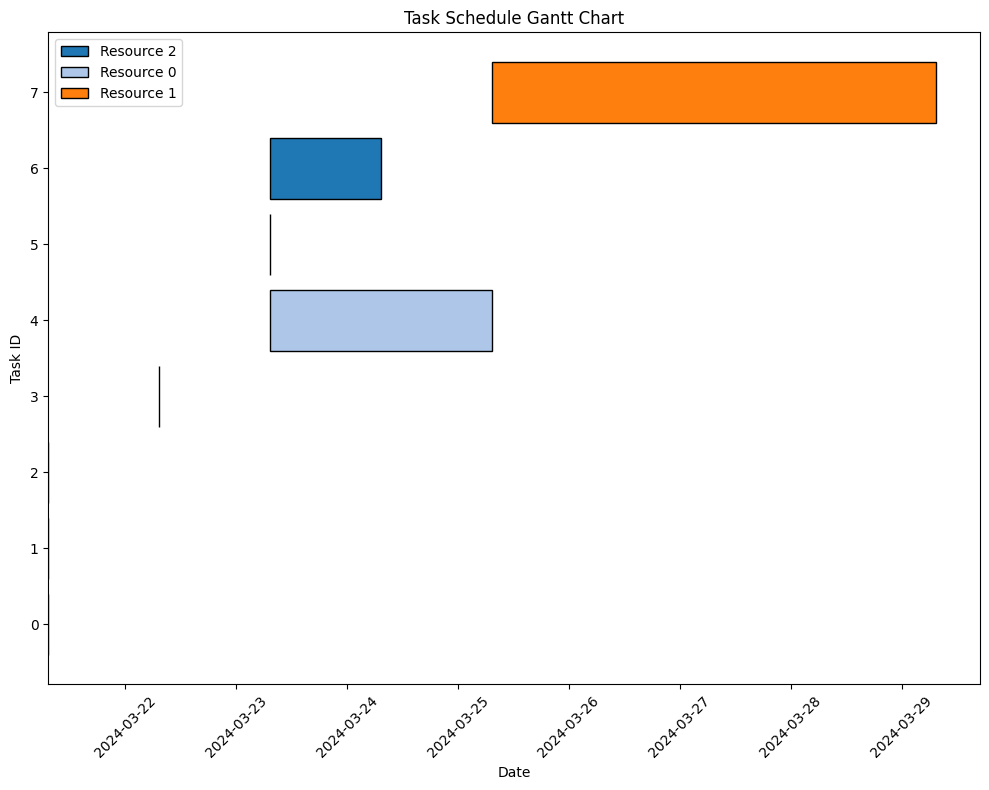

In [8]:
limited_tasks, limited_resources = load_dataframes(limited_pcm_sched_path, limited_pcm_resources_path)
limited_schedule_df = heuristic_schedule(limited_tasks, limited_resources)
plot_gantt_chart(limited_schedule_df)

#### Full PCM Schedule

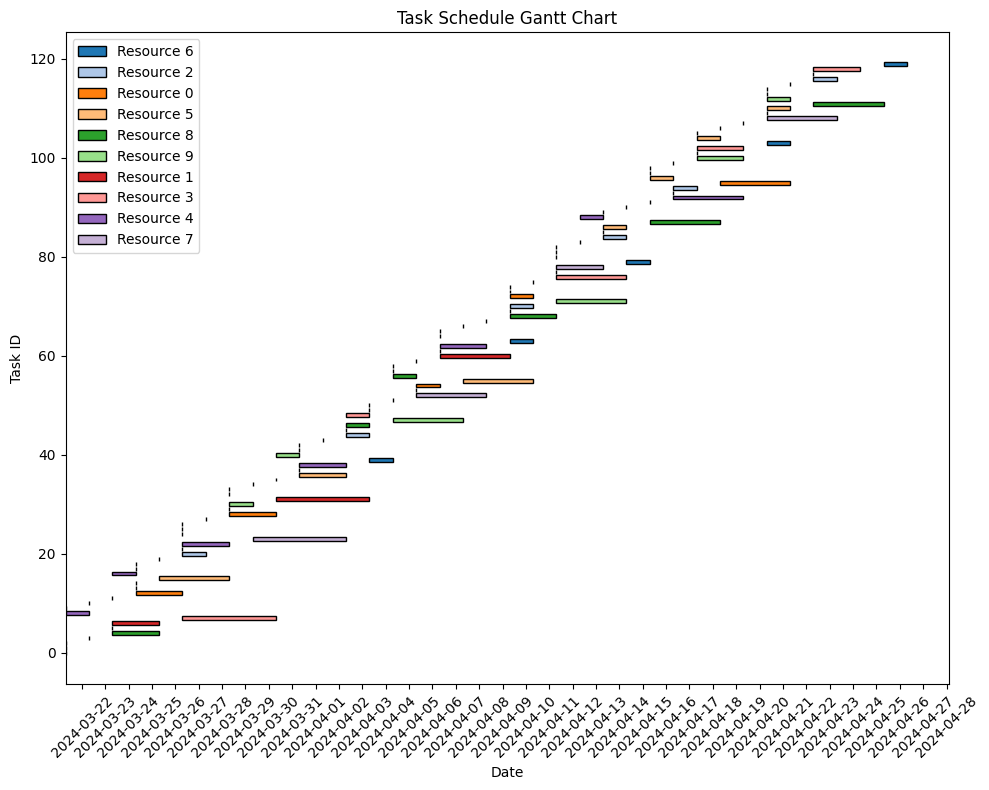

In [9]:
full_tasks, full_resources = load_dataframes(full_pcm_sched_path, full_pcm_resources_path)
full_schedule_df = heuristic_schedule(full_tasks, full_resources)
plot_gantt_chart(full_schedule_df)

### Heuristics - Resource-Fit Scheduling

#### Limited PCM Schedule

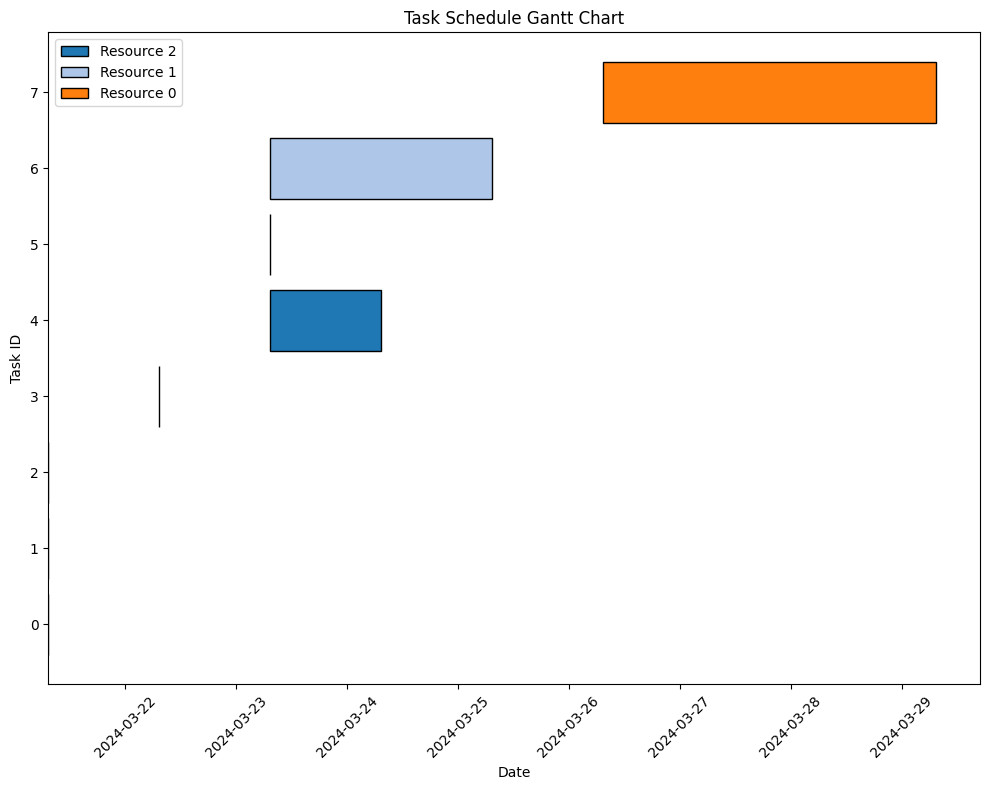

In [10]:
limited_tasks, limited_resources = load_dataframes(limited_pcm_sched_path, limited_pcm_resources_path)
limited_schedule_df = heuristic_schedule_fit(limited_tasks, limited_resources)
plot_gantt_chart(limited_schedule_df)

#### Full PCM Schedule

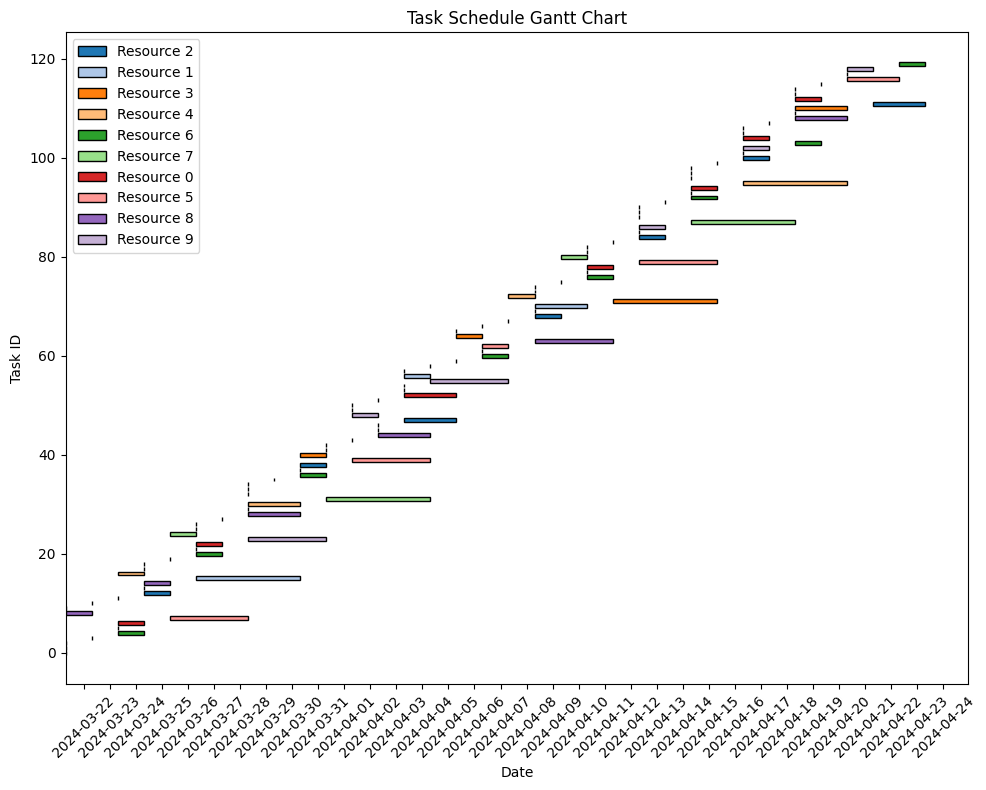

In [11]:
full_tasks, full_resources = load_dataframes(full_pcm_sched_path, full_pcm_resources_path)
full_schedule_df = heuristic_schedule_fit(full_tasks, full_resources)
plot_gantt_chart(full_schedule_df)

### Simulated Annealing

#### Limited PCM Schedule

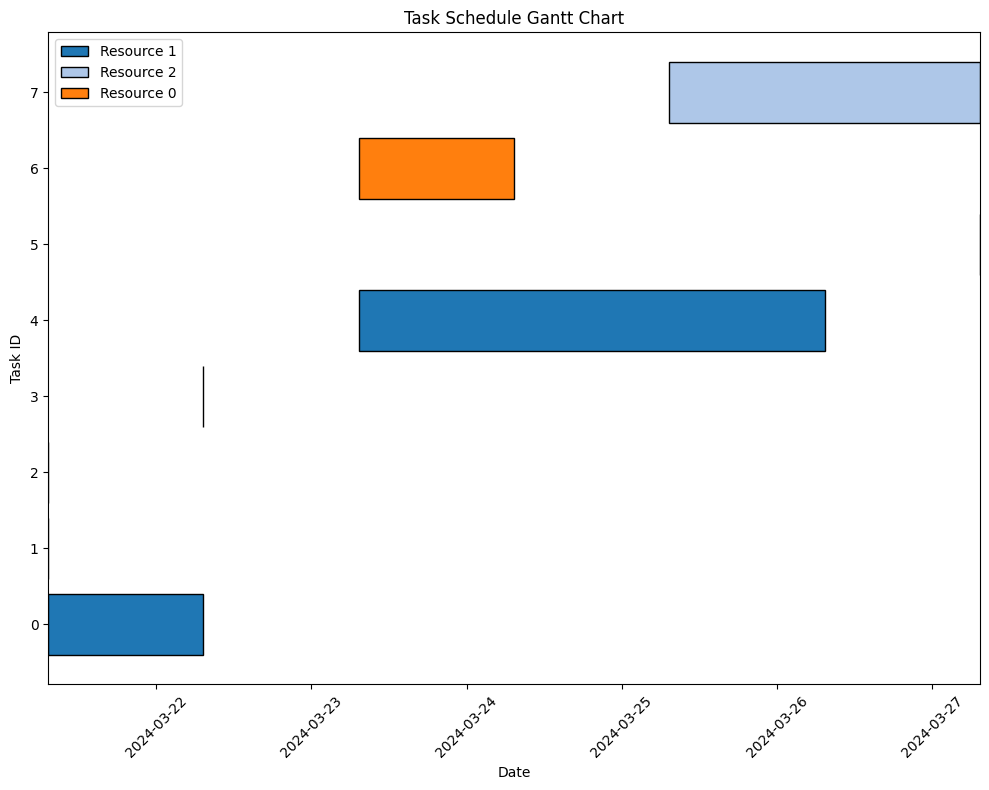

In [12]:
limited_tasks, limited_resources = load_dataframes(limited_pcm_sched_path, limited_pcm_resources_path)
limited_schedule_df = simulated_annealing_wrapper(limited_tasks, limited_resources)
plot_gantt_chart(limited_schedule_df)

#### Full PCM Schedule

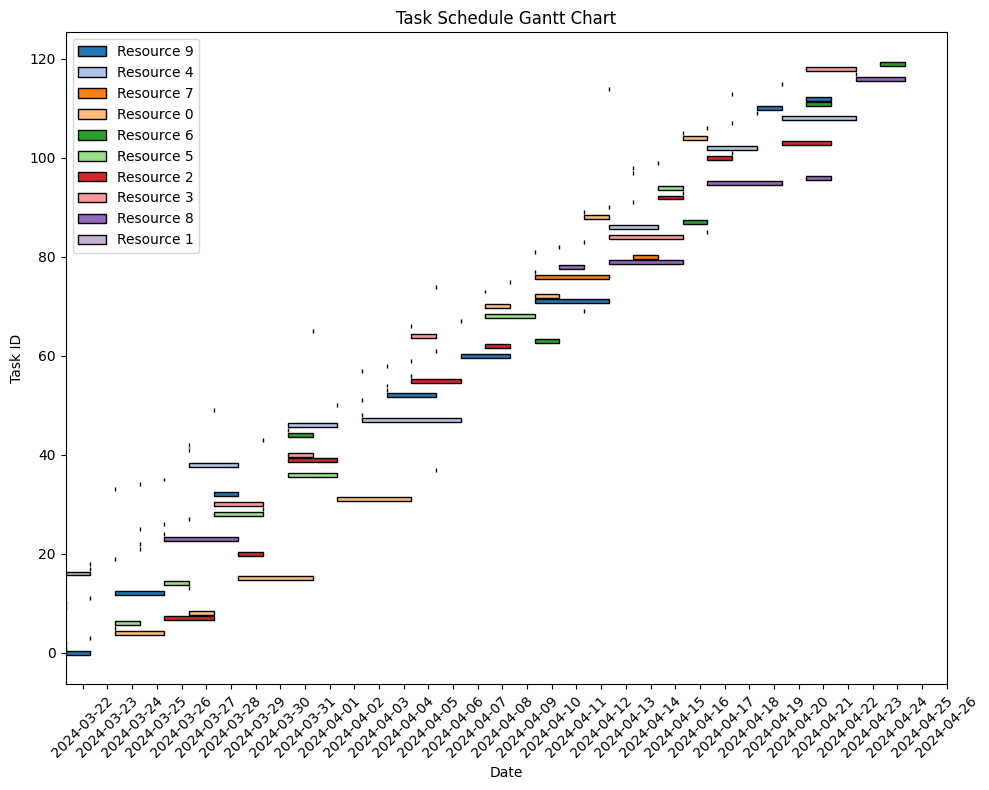

In [13]:
full_tasks, full_resources = load_dataframes(full_pcm_sched_path, full_pcm_resources_path)
full_schedule_df = simulated_annealing_wrapper(full_tasks, full_resources)
plot_gantt_chart(full_schedule_df)

## Comparative Study

In [14]:
def compare_scheduling_algorithms(datasets):
    # Dictionary to hold the comparison results
    results = {
        'Algorithm': [],
        'Dataset': [],
        'Runtime (s)': [],
        'Total Project Duration (days)': [],
        'Average Resource Utilization': []
    }

    # List of algorithms to compare
    algorithms = [
        ('Heuristic Schedule', heuristic_schedule),
        ('Heuristic Schedule Fit', heuristic_schedule_fit),
        ('Simulated Annealing', simulated_annealing_wrapper)
    ]

    # Run each algorithm with each dataset
    for dataset_name, (tasks_path, resources_path) in datasets.items():
        tasks_df = pd.read_csv(tasks_path)
        resources_df = pd.read_csv(resources_path)
        
        for algorithm_name, algorithm_func in algorithms:
            start_time = time.time()
            schedule_df = algorithm_func(tasks_df.copy(), resources_df.copy())
            runtime = time.time() - start_time

            # Assuming 'end_day' column for total project duration calculation
            total_project_duration = schedule_df['end_day'].max()
            # Simple resource utilization calculation: number of tasks / number of resources
            resource_utilization = len(schedule_df) / len(resources_df)

            # Append results
            results['Algorithm'].append(algorithm_name)
            results['Dataset'].append(dataset_name)
            results['Runtime (s)'].append(runtime)
            results['Total Project Duration (days)'].append(total_project_duration)
            results['Average Resource Utilization'].append(resource_utilization)

    # Convert results to DataFrame for easier handling
    results_df = pd.DataFrame(results)
    return results_df


In [15]:
# Define the datasets
datasets = {
    'Limited PCM': ('./data/limited_pcm_execution_schedule.csv', './data/limited_pcm_resources.csv'),
    'Full PCM': ('./data/full_pcm_execution_schedule.csv', './data/full_pcm_resources.csv')
}

# Compare and visualize
results_df = compare_scheduling_algorithms(datasets)
results_df

,Algorithm,Dataset,Runtime (s),Total Project Duration (days),Average Resource Utilization
0,Heuristic Schedule,Limited PCM,0.007167,9,2.666667
1,Heuristic Schedule Fit,Limited PCM,0.011801,9,2.666667
2,Simulated Annealing,Limited PCM,3.560924,7,2.666667
3,Heuristic Schedule,Full PCM,0.074773,37,12.000000
4,Heuristic Schedule Fit,Full PCM,0.121457,34,12.000000
5,Simulated Annealing,Full PCM,28.950196,35,12.000000
